In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import hasasia.sensitivity as hsen
from tqdm import tqdm
import pickle

In [2]:
from itertools import combinations
from math import comb

In [4]:
Npulsars = 150
n = np.arange(2,Npulsars)

samples = []
for jj,nn in tqdm(enumerate(n)):
    # npairs = Npairs(nn)
    samples.append([])
    for ii in range(100):
        phis = np.random.uniform(0,2*np.pi,size=nn)
        cosThetas = np.random.uniform(-1,1,size=nn)
        thetas = np.arccos(cosThetas)
        _,chiIJ,_,_ = hsen.HellingsDownsCoeff(phi=phis,theta=thetas)
        samples[jj].append(np.mean(chiIJ**2))



148it [01:46,  1.39it/s]


In [5]:
samples = np.array(samples)

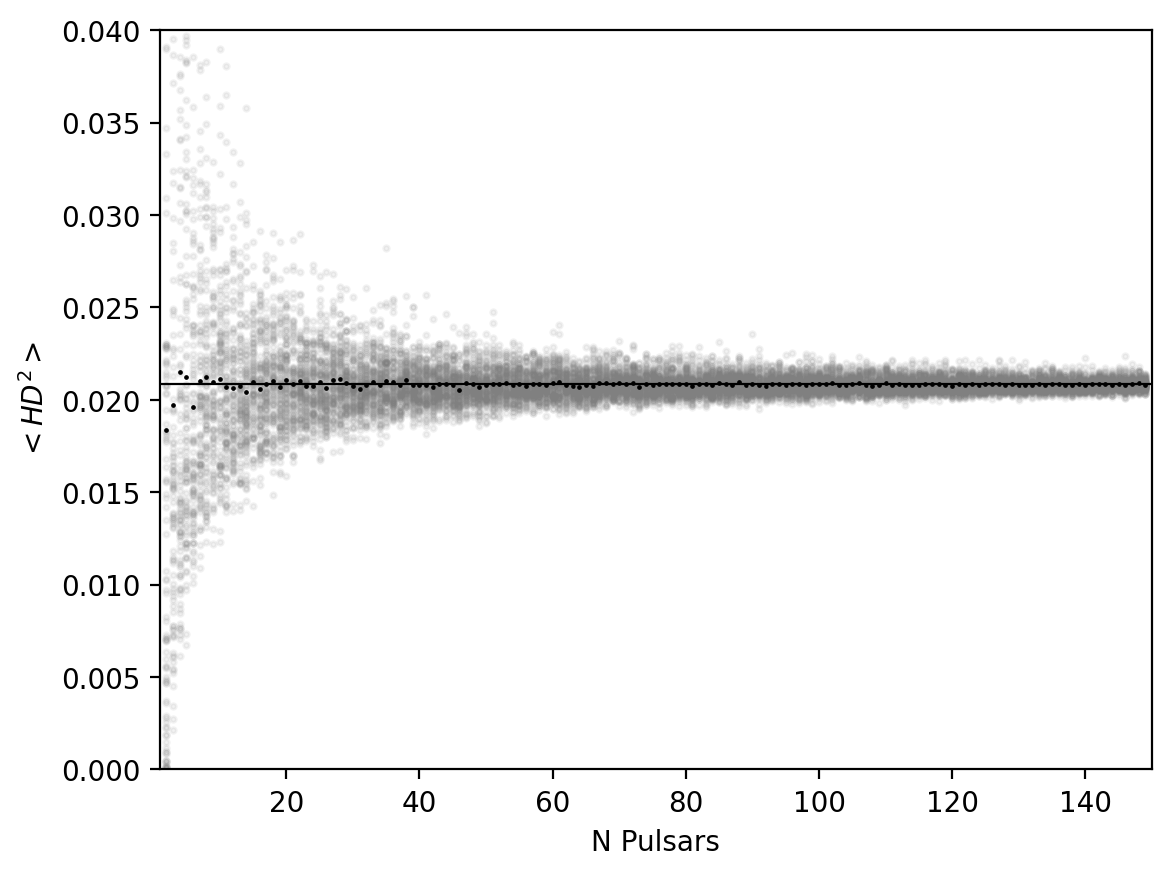

In [6]:
for ii in n:
    plt.scatter(ii*np.ones(100),samples[ii-2,:],s=4,color='gray',alpha=0.1)
    plt.scatter(ii,np.mean(samples[ii-2,:]),s=2,marker='.',color='k')

plt.xlim(1,Npulsars)
plt.ylim(0,.04)
plt.axhline(1/48,color='k',linewidth=0.8,zorder=3)
plt.ylabel('$<HD^2>$')
plt.xlabel('N Pulsars')
plt.show()

In [12]:
pidx = np.arange(1,122)

$$
\begin{align*}
N_{\rm pairs}&=\sum_I^{N_{\rm PTA}} \binom{N_I}{2} + \sum_I^{N_{\rm PTA}} \sum_{J>I}^{N_{\rm PTA}} N_I\;N_J - N_{\rm In All}\binom{N_{\rm PTA}}{2} - \sum_a^{N_{\rm PTA}-1} \sum_{\alpha}^{\binom{N_{\rm PTA}}{a}} \binom{a}{2} N_\alpha^a \\
&= \binom{\sum_I^{N_{\rm PTA}} N_I}{2}  - N_{\rm In All}\binom{N_{\rm PTA}}{2} - \sum_a^{N_{\rm PTA}-1} \sum_{\alpha}^{\binom{N_{\rm PTA}}{a}} \binom{a}{2} N_\alpha^a \\
&= \binom{\sum_I^{N_{\rm PTA}} N_I}{2} - \sum_a^{N_{\rm PTA}} \sum_{\alpha}^{\binom{N_{\rm PTA}}{a}} \binom{a}{2} N_\alpha^a
\end{align*}
$$

Here $N_I$ is the number of pulsars in each PTA, $I$ runs over each PTA, $a$ is the number of PTAs by which a pulsar is observed ($a=2...N_{\rm PTA}$), $\alpha$ is an index over all of the combinations of overlaps with a given valence $a$, where $\alpha=1...\binom{N_{\rm PTA}}{a}$.

In [13]:
NPTA = 3
def make_ptas(NPTA=None, pidx=None, Np_range=[25,70]):
    ptas = []
    for ii in range(1,NPTA+1):
        Np = np.random.randint(low=Np_range[0],high=Np_range[1])
        pta = np.sort(np.random.choice(pidx,size=Np))
        ptas.append(pta.tolist())
    return ptas

def Npairs(ptas,all_overlap=True,overlap=True,pidx=None):
    r"""
    \[
    N_{\rm pairs}&=\sum_I^{N_{\rm PTA}} \binom{N_I}{2} + \sum_I^{N_{\rm PTA}} \sum_{J>I}^{N_{\rm PTA}} N_I\;N_J - N_{\rm In All}\binom{N_{\rm PTA}}{2} - \sum_a^{N_{\rm PTA}-1} \sum_{\alpha}^{\binom{N_{\rm PTA}}{2}} \binom{a}{2} N_\alpha^a \\
    \]
    """
    
    npairs = np.sum([comb(len(p),2) for p in ptas])
    npairs += np.sum([[len(pi)*len(pj) if jj >ii else 0 for jj,pj in enumerate(ptas) ]
                      for ii, pi in enumerate(ptas)])
    
    if all_overlap:
        N_ao = 0
        for p in pidx:
            if all([p in pta for pta in ptas]):
                N_ao +=1
        npairs -= N_ao * comb(len(ptas),2)

    if overlap:
        N_o = 0
        for a in range(2,len(ptas)):
            for pta_set in combinations(ptas,a):
                N_o += comb(a,2) * np.sum([1 for p in pidx
                                           if all([p in pta for pta in pta_set])])

        npairs -= N_o
    return npairs

In [9]:
ptas = make_ptas(NPTA,pidx=pidx)

In [14]:
with open("/Users/kalistaw/Desktop/OS_2023_data/puslar_name_list", "rb") as fp:  
    ptas = pickle.load(fp)

In [15]:
Npairs(ptas,pidx=pidx,all_overlap=False,overlap=False), Npairs(ptas,pidx=pidx,all_overlap=True,overlap=True), comb(np.sum([len(pta) for pta in ptas]),2)

(7381, 7381.0, 7381)

In [11]:
n1=Npairs([[1,2,3],[4,5,6],[7,8,9]],
          pidx=[1,2,3,4,5,6,7,8,9],
          all_overlap=False,
          overlap=False)
n2=Npairs([[1,2,3],[4,5,6],[7,8,9]],
          pidx=[1,2,3,4,5,6,7,8,9],
          all_overlap=True,
          overlap=True)
n1,n2

(36, 36.0)

In [19]:
small_ptas = [[1,2,3],[4,5,3],[3,3,9]]
small_pidx = [1,2,3,4,5,6,7,8,9]

n1=Npairs(small_ptas,
          pidx=small_pidx,
          all_overlap=False,
          overlap=False)

n2=Npairs(small_ptas,
          pidx=small_pidx,
          all_overlap=True,
          overlap=True)
n1,n2

(36, 30)

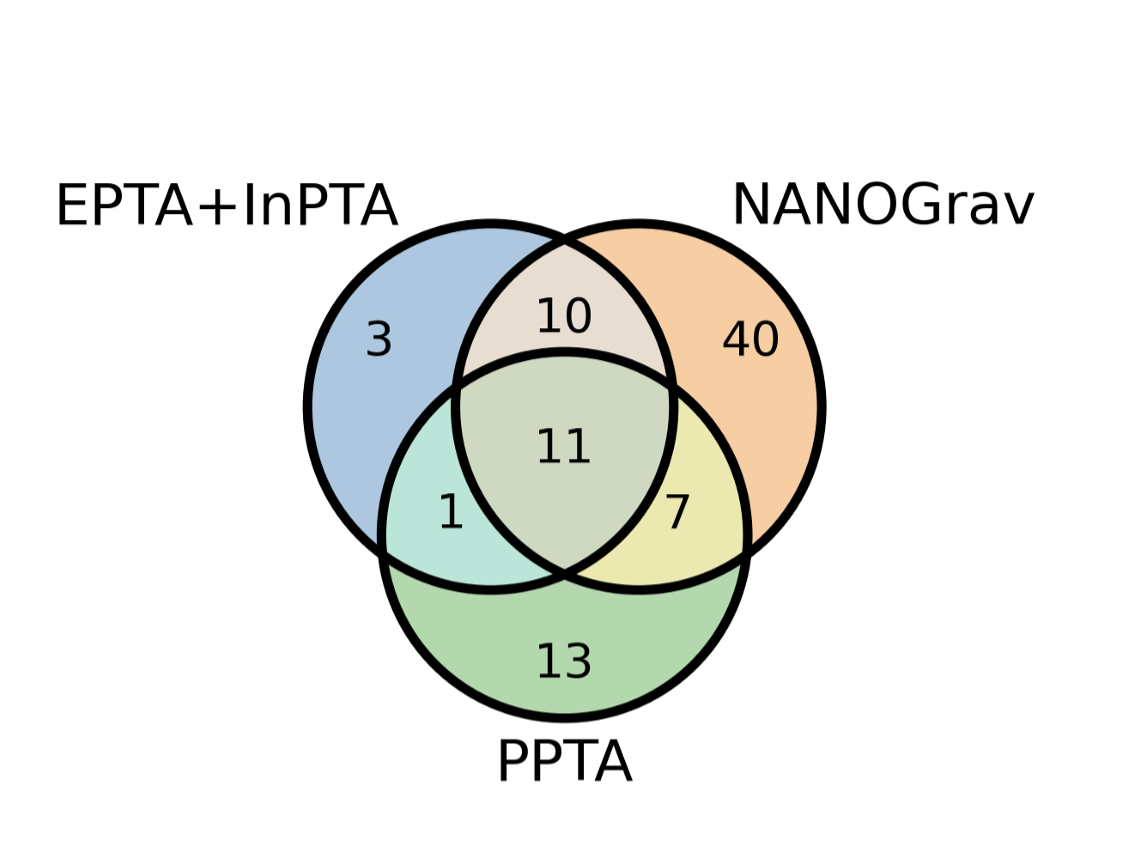

In [14]:
def Npairs2(NI,Nall=None,Na=None):
    npairs = np.sum([comb(n,2) for n in NI])
    npairs += np.sum([[ni*nj if jj >ii else 0 for jj,nj in enumerate(NI) ]
                      for ii, ni in enumerate(NI)])
    if Nall is not None:
        npairs -= Nall * comb(len(NI),2)
    if Na is not None:
        for a, overlap in enumerate(Na):
            for npsrs in overlap:
                npairs -= comb(a+2,2) * npsrs
    return npairs

IPTA0 = Npairs2(NI=[25,68,32])
IPTA1 = Npairs2(NI=[25,68,32],
                Nall = 11,
                Na = [[1,10,7]])
IPTA0, IPTA1

(7750, 7699)

Ok, now let's predict the S/N, $\rho$, for the IPTA knowing $\rho_{\rm NG}$ and the ratio of the numbers of pairs
$$\frac{\rho_1^2}{\rho_2^2}=\frac{N_{\rm pairs}^{(1)}}{N_{\rm pairs}^{(2)}}$$

In [16]:
np.round(4.5*np.sqrt(IPTA1/comb(68,2)),1)

8.3

Since the EPTA has a large value for the average of the average $\zeta^2$, then maybe it's worth just calculating the difference in the actual HD calculations for the IPTA. 

## Combination of datasets
Combining the data will change the sensitivity of pulsars which are observed by multiple PTAs. A simple, unrealistic assumption would be that the RMS of the residuals in a pular would decrease as the usual $\sigma \rightarrow \sigma/\sqrt{N}$, where $N$ is the number of TOAs.

What are the tweaks that we would need for the code above?
* Assume that the number of data points is multiplied by the number of PTAs it is observed by.
* Increase the S/N according to the factors of the multiple valence pulsars. How would this work?

$$\rho^2\sim \frac{S^2_h}{\sigma^2}$$